In [1]:
import numpy as np
import matplotlib.pyplot as plt
import src.fitting as fitting
import src.multielec_utils as mutils
from scipy.io import savemat, loadmat
import multiprocessing as mp
import statsmodels.api as sm

%matplotlib inline
%load_ext autoreload
%autoreload 2

# 1D, single-sided

In [ ]:
GSORT_BASE = "/Volumes/Scratch/Analysis"
ANALYSIS_BASE = "/Volumes/Analysis"
dataset = "2022-11-28-1"
wnoise = "data010"
# blanked_probs = 0

estim_neg = "data009"

outpath = os.path.join(GSORT_BASE, dataset, estim_neg, wnoise)
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim_neg)
parameters = loadmat(os.path.join(outpath, 'parameters.mat'))

cells = parameters['cells'].flatten()
num_cells = len(cells)
num_patterns = max(parameters['patterns'].flatten())
num_movies = parameters['movies'].flatten()[0]

all_probs_neg = np.array(np.memmap(os.path.join(outpath, 'init_probs.dat'),mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32'))
trials_neg = np.array(np.memmap(os.path.join(outpath, 'trial.dat'),mode='r',shape=(num_patterns, num_movies), dtype='int16'), dtype=int)
amps_neg = np.array([mutils.get_stim_amps_newlv(electrical_path, 1).reshape(-1, 1)] * len(trials_neg))

# Processing data below: do other stuff if your pipeline is different
# all_probs_neg[:, :, :blanked_probs] = np.zeros(all_probs_neg[:, :, :blanked_probs].shape)

for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        all_probs_neg[i][j] = fitting.disambiguate_sigmoid(all_probs_neg[i][j], spont_limit=0.4, noise_limit=0.1)

In [ ]:
ms = [1]

w_inits_array = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]), dtype=object)
for i in range(len(w_inits_array)):
    for j in range(len(w_inits_array[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps_neg[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array[i][j] = w_inits

In [ ]:
input_list = fitting.generate_input_list(all_probs_neg, amps_neg, trials_neg, w_inits_array)

pool = mp.Pool(processes=24)
results = pool.starmap_async(fitting.fit_surface, input_list)
mp_output = results.get()
pool.close()

In [ ]:
params_true = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]), dtype=object)
inits = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]), dtype=object)

probs_true = np.zeros(all_probs_neg.shape)
cnt = 0
for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        params_true[i][j] = mp_output[cnt][0]
        inits[i][j] = mp_output[cnt][1]
        
        probs_true[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps_neg[j], has_constant='add'), 
                                params_true[i][j])

        cnt += 1

In [ ]:
# CHECK DATASET IF NEEDED

for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            print(params_true[i][j])
            
            plt.figure(0)
            plt.xlim(-4.2, 0.1)
            plt.ylim(-0.1, 1.1)
            plt.scatter(amps_neg[j].flatten(), all_probs_neg[i][j])
            plt.plot(amps_neg[j].flatten(), probs_true[i][j])
            plt.show()
            input()

# 1D, oldlv

In [2]:
Ivals = np.array([0.10053543, 0.11310236, 0.11938583, 0.13195276, 0.14451969,                        
                       0.16337008, 0.17593701, 0.1947874 , 0.2136378 , 0.23877165,
                       0.25762205, 0.2780315 , 0.30330709, 0.35385827, 0.37913386,
                       0.42968504, 0.45496063, 0.50551181, 0.55606299, 0.60661417,
                       0.68244094, 0.73299213, 0.8088189 , 0.88464567, 0.98574803,
                       1.10433071, 1.20472441, 1.30511811, 1.40551181, 1.60629921,
                       1.70669291, 1.90748031, 2.10826772, 2.30905512, 2.50984252,
                       2.81102362, 3.11220472, 3.41338583, 3.71456693, 4.1161])

In [3]:
GSORT_BASE = "/Volumes/Scratch/Users/bhofflic/gsort"
ANALYSIS_BASE = "/Volumes/Analysis"
dataset = "2022-05-16-3"
wnoise = "streamed/data000"
blanked_probs = 12

estim_neg = "data001"

outpath = os.path.join(GSORT_BASE, dataset, estim_neg, wnoise)
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim_neg)
parameters = loadmat(os.path.join(outpath, 'parameters.mat'))

cells = parameters['cells'].flatten()
num_cells = len(cells)
num_patterns = max(parameters['patterns'].flatten())
num_movies = parameters['movies'].flatten()[0]

all_probs_neg = np.array(np.memmap(os.path.join(outpath, 'init_probs.dat'),mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32'))
trials_neg = np.array(np.memmap(os.path.join(outpath, 'trial.dat'),mode='r',shape=(num_patterns, num_movies), dtype='int16'), dtype=int)
amps_neg = np.array([-Ivals.reshape(-1, 1)] * len(trials_neg))

# Processing data below: do other stuff if your pipeline is different
all_probs_neg[:, :, :blanked_probs] = np.zeros(all_probs_neg[:, :, :blanked_probs].shape)

for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        good_inds = np.where(~np.isnan(all_probs_neg[i][j]))[0]
        if len(good_inds) > 0:
            all_probs_neg[i][j][good_inds] = fitting.disambiguate_sigmoid(all_probs_neg[i][j][good_inds], spont_limit=0.4, noise_limit=0.1)

In [4]:
ms = [1]

w_inits_array = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]), dtype=object)
for i in range(len(w_inits_array)):
    for j in range(len(w_inits_array[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps_neg[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array[i][j] = w_inits

In [5]:
input_list = fitting.generate_input_list(all_probs_neg, amps_neg, trials_neg, w_inits_array)

pool = mp.Pool(processes=24)
results = pool.starmap_async(fitting.fit_surface, input_list)
mp_output = results.get()
pool.close()

In [6]:
params_true = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]), dtype=object)
inits = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]), dtype=object)

probs_true = np.zeros(all_probs_neg.shape)
cnt = 0
for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        params_true[i][j] = mp_output[cnt][0]
        inits[i][j] = mp_output[cnt][1]
        
        probs_true[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps_neg[j], has_constant='add'), 
                                params_true[i][j])

        cnt += 1

[[-20.30653558  -9.98150806]]


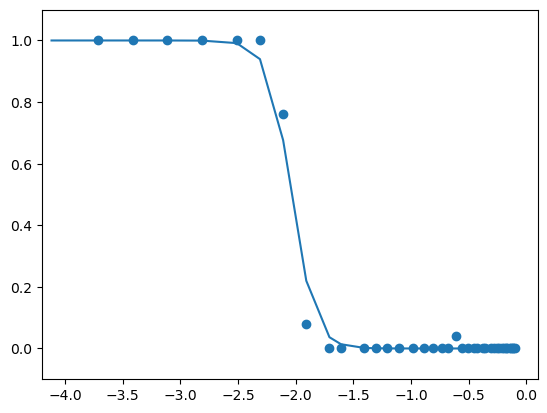

[[-12.32162132 -10.        ]]


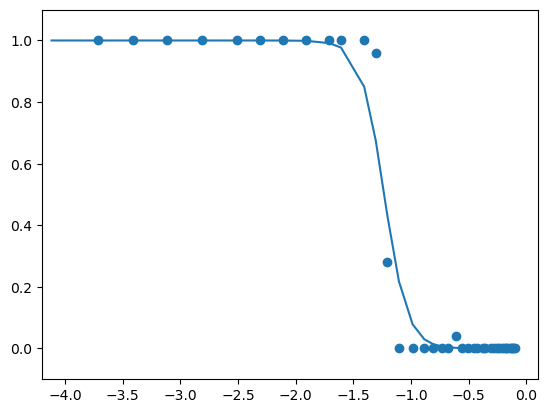

[[-11.14394698 -10.        ]]


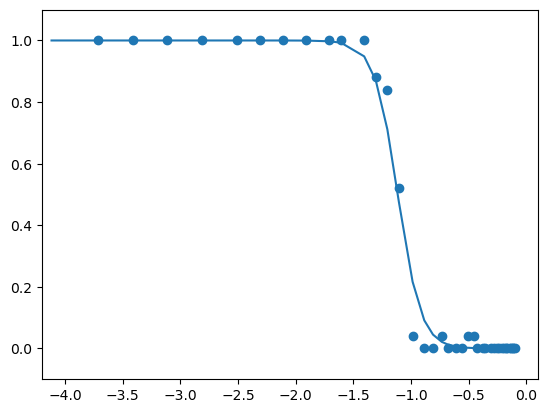

[[-6.31374986 -0.9362854 ]]


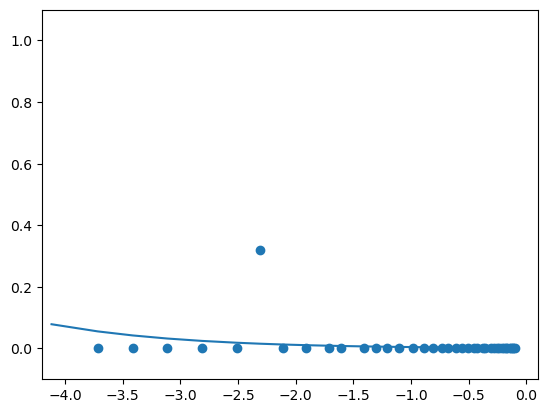

[[-12.71462994 -10.        ]]


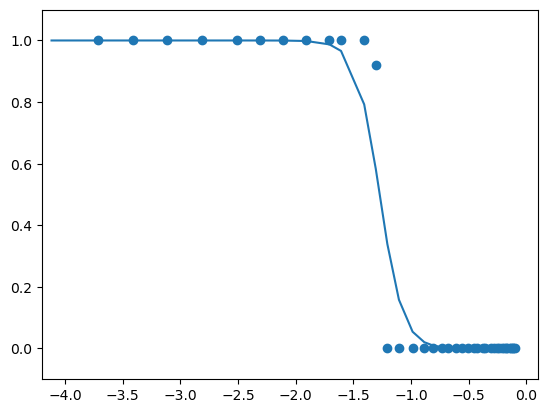

[[-14.19312429 -10.        ]]


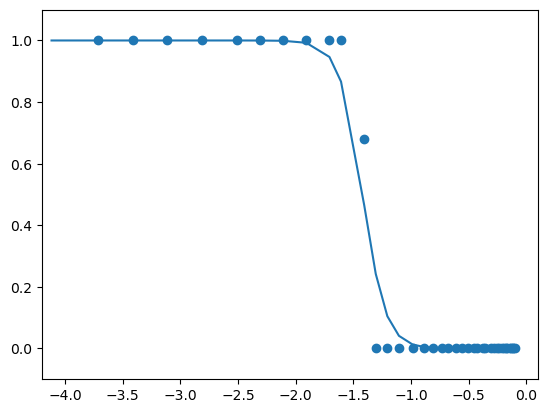

[[-18.01736331  -8.32758938]]


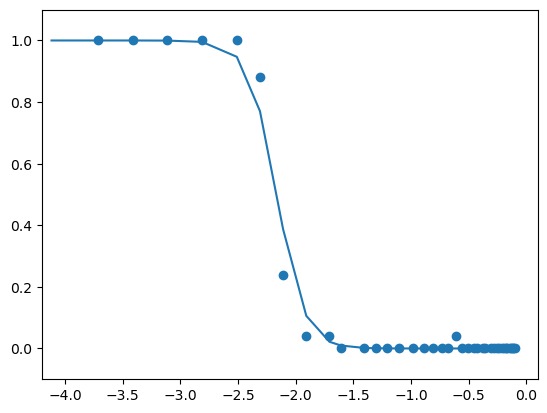

[[-22.18174004 -10.        ]]


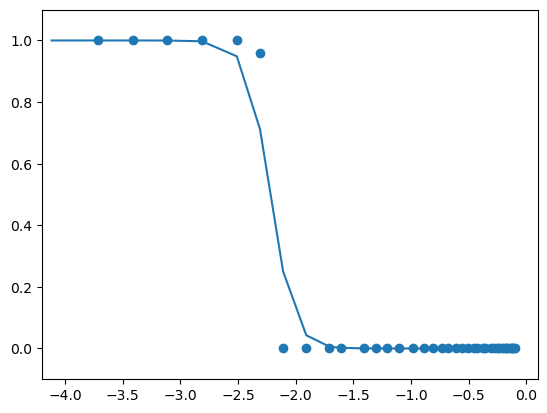

[[-27.25948601 -10.        ]]


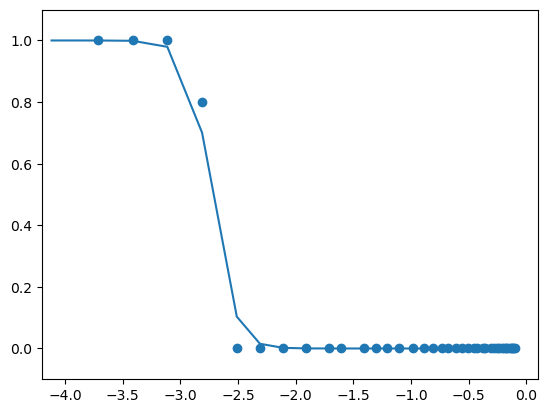

[[-25.36296129 -10.        ]]


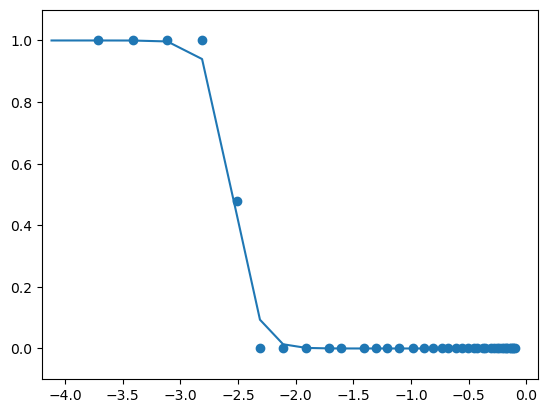

[[-6.19729614 -0.93824549]]


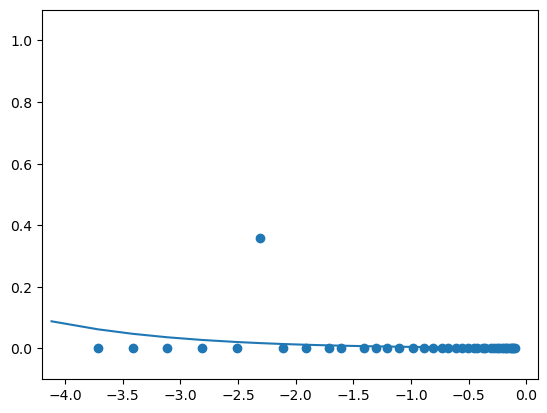

[[-32.72140434  -9.70164837]]


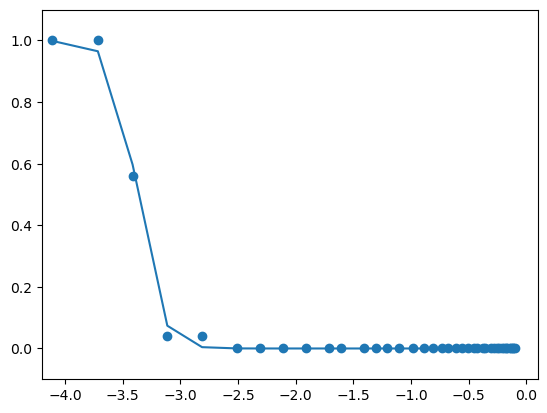

[[-5.50076421 -2.58384302]]


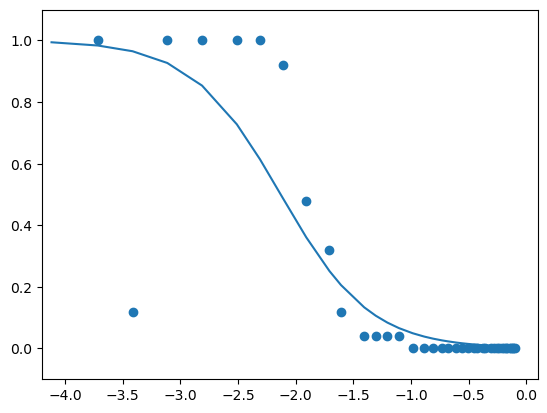

[[-14.45656477  -4.70970949]]


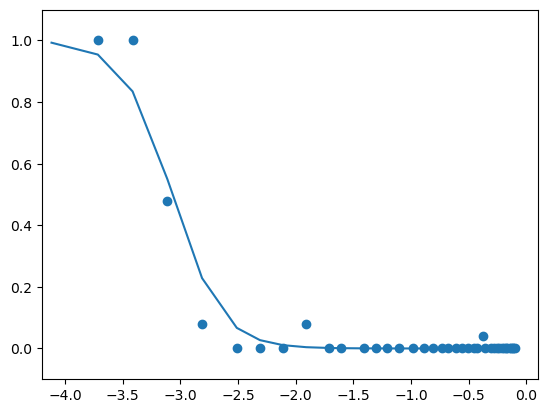

[[-29.72775034  -9.91132444]]


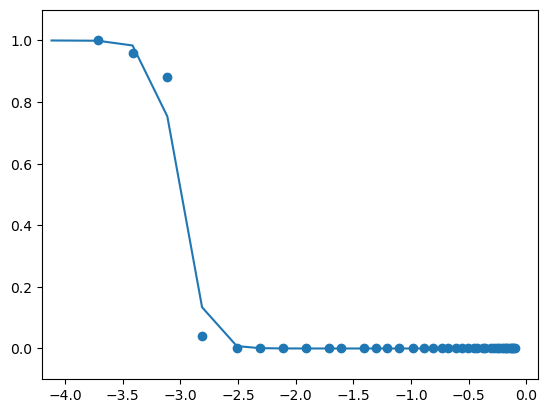

[[-25.26516926 -10.        ]]


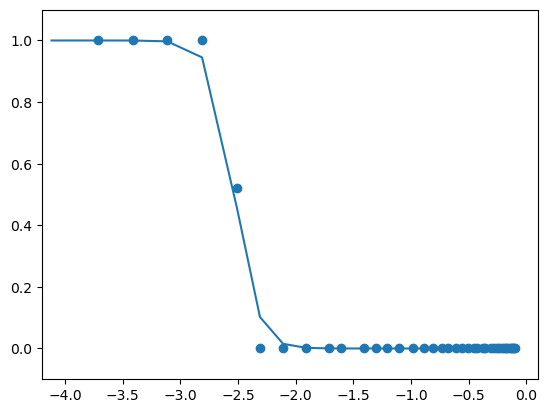

[[-22.11887987  -9.20908425]]


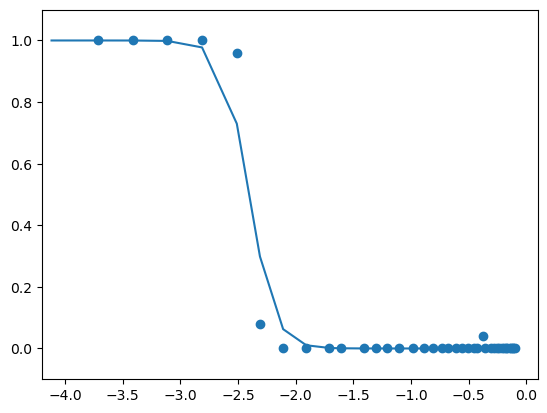

[[-27.25948633 -10.        ]]


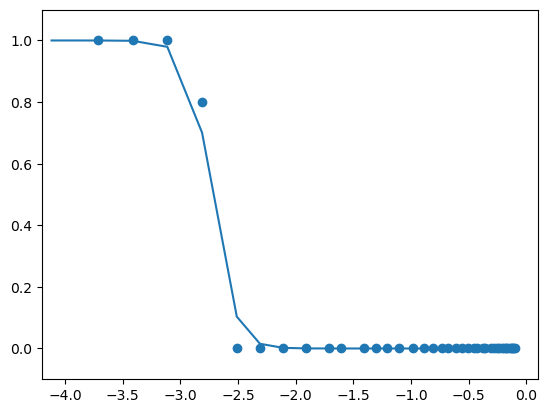

KeyboardInterrupt: Interrupted by user

In [7]:
# CHECK DATASET IF NEEDED

for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            print(params_true[i][j])
            
            plt.figure(0)
            plt.xlim(-4.2, 0.1)
            plt.ylim(-0.1, 1.1)
            plt.scatter(amps_neg[j].flatten(), all_probs_neg[i][j])
            plt.plot(amps_neg[j].flatten(), probs_true[i][j])
            plt.show()
            input()

# Multi-elec

In [ ]:
GSORT_BASE = "/Volumes/Scratch/Analysis"
ANALYSIS_BASE = "/Volumes/Analysis"
dataset = "2020-10-06-7"
wnoise = "kilosort_data000/data000"

estim_neg = "data003/data003-all"

outpath = os.path.join(GSORT_BASE, dataset, estim_neg, wnoise)
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim_neg)
parameters = loadmat(os.path.join(outpath, 'parameters.mat'))
spont_limit = 0.3   # this needs to be the same value as min_prob in fit_surface()
min_active_inds = 200

cells = parameters['cells'].flatten()
num_cells = len(cells)
num_patterns = max(parameters['patterns'].flatten())
num_movies = parameters['movies'].flatten()[0]

all_probs = np.array(np.memmap(os.path.join(outpath, 'init_probs.dat'),mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32'))
trials = np.array(np.memmap(os.path.join(outpath, 'trial.dat'),mode='r',shape=(num_patterns, num_movies), dtype='int16'), dtype=int)
amps = np.array([mutils.get_stim_amps_newlv(electrical_path, 1)] * len(trials))

clean_inds_array = np.full((all_probs.shape[0], all_probs.shape[1]), 
                            None, dtype=object)

for i in np.where((cells == 292))[0]:#range(len(all_probs)):
    for j in [1]:#range(len(all_probs[i])):

        if all_probs[i][j].max() >= spont_limit:
            print(cells[i], j+1)
            clean_inds = mutils.triplet_cleaning(amps[j], all_probs[i][j], trials[j],
                                                 return_inds=True)
            above_spont = np.where(all_probs[i][j][clean_inds] >= spont_limit)[0]
            if len(above_spont) >= min_active_inds:
                clean_inds_array[i][j] = clean_inds

In [ ]:
ms = [1, 2, 3, 4, 5, 6]

w_inits_array = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)
for i in range(len(w_inits_array)):
    for j in range(len(w_inits_array[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array[i][j] = w_inits

In [ ]:
input_list = fitting.generate_input_list(all_probs, amps, trials, w_inits_array,
                                         pass_inds=clean_inds_array)

pool = mp.Pool(processes=24)
results = pool.starmap_async(fitting.fit_surface, input_list)
mp_output = results.get()
pool.close()

In [ ]:
params_true = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)
inits = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)

probs_true = np.zeros(all_probs.shape)
cnt = 0
for i in range(len(all_probs)):
    for j in range(len(all_probs[i])):
        params_true[i][j] = mp_output[cnt][0]
        inits[i][j] = mp_output[cnt][1]
        
        probs_true[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps[j], has_constant='add'), 
                                params_true[i][j])

        cnt += 1

In [ ]:
# CHECK DATASET IF NEEDED
from mpl_toolkits.mplot3d import Axes3D

for i in range(len(all_probs)):
    for j in range(len(all_probs[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            print(cells[i], j+1)
            print(params_true[i][j])
            print(len(np.where(all_probs[i][j][clean_inds_array[i][j]] >= spont_limit)[0]))
            
            fig = plt.figure(0)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps[j][:, 0], 
                              amps[j][:, 1],
                              amps[j][:, 2], marker='o', 
                              c=probs_true[i][j], s=20, alpha=0.8, vmin=0, vmax=1)
            plt.show()

            fig = plt.figure(1)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps[j][clean_inds_array[i][j], 0], 
                              amps[j][clean_inds_array[i][j], 1],
                              amps[j][clean_inds_array[i][j], 2], marker='o', 
                              c=all_probs[i][j][clean_inds_array[i][j]], s=20, alpha=0.8, vmin=0, vmax=1)
            plt.show()

            input()

In [ ]:
savemat('pc_292experimental.mat', {'pc': amps[1][clean_inds_array[np.where(cells == 292)[0][0]][1]],
        'probs': all_probs[np.where(cells == 292)[0][0]][1][clean_inds_array[np.where(cells == 292)[0][0]][1]]})

In [ ]:
currs_1d = np.linspace(-2.2, 2.2, 80)
X_plot = np.array(np.meshgrid(currs_1d, currs_1d, currs_1d)).T.reshape(-1,3)
probs_pred = fitting.sigmoidND_nonlinear(sm.add_constant(X_plot, has_constant='add'), 
                                         params_true[np.where(cells == 292)[0][0]][1])

In [ ]:
fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-2.2, 2.2)
plt.ylim(-2.2, 2.2)
ax.set_zlim(-2.2, 2.2)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_plot[:, 0], 
            X_plot[:, 1],
            X_plot[:, 2], marker='o', 
            c=probs_pred, 
            s=20, alpha=0.8, vmin=0, vmax=1)

In [ ]:
boundary_inds = np.where(np.absolute(probs_pred - 0.5) <= 0.01)[0]

In [ ]:
savemat('pc_292_extended.mat', {'pc': X_plot[boundary_inds]})